In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
from tensorflow import ConfigProto
from tensorflow import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
training_set = train_datagen.flow_from_directory('train_new',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 3687 images belonging to 2 classes.


In [6]:
valid_set = valid_datagen.flow_from_directory('valid',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 806 images belonging to 2 classes.


In [7]:
# Using the mobilenet152v2 architecture pre tained on imagenet dataset

image_size = [224,224]
mobilenet =  tf.keras.applications.MobileNetV2(input_shape = image_size +[3], weights ='imagenet', include_top = False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
mobilenet.summary

<bound method Network.summary of <tensorflow.python.keras.engine.training.Model object at 0x7fabf463bef0>>

In [9]:
for layer in mobilenet.layers[0:-4]:
    print (layer)
    layer.trainable = False


In [10]:
flatten_layer = Flatten()(mobilenet.output)

In [11]:
dense_1 = Dense(128, activation = 'relu')(flatten_layer)
output = Dense(2, activation ='softmax' )(dense_1)
model = Model(inputs = mobilenet.input, outputs = output )

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [13]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+keras.backend.epsilon()))

In [14]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
             )

In [15]:
model_path = '.'
checkpoint = ModelCheckpoint(model_path, monitor = 'val_accuracy', verbose = 1, save_best_only = True)
callback_ = [checkpoint]

In [19]:
mdl = model.fit(training_set,
               validation_data= valid_set,
               epochs = 15,
               steps_per_epoch = len(training_set),
               validation_steps = len(valid_set),
               callbacks = callback_)

Epoch 1/15
116/116 [==============================] - 31s 265ms/step - loss: 0.0133 - acc: 0.9951 - precision: 0.9951 - recall: 0.9951 - val_loss: 0.1345 - val_acc: 0.9640 - val_precision: 0.9640 - val_recall: 0.9640
Epoch 2/15
116/116 [==============================] - 27s 233ms/step - loss: 0.0075 - acc: 0.9973 - precision: 0.9973 - recall: 0.9973 - val_loss: 0.1184 - val_acc: 0.9777 - val_precision: 0.9777 - val_recall: 0.9777
Epoch 3/15
116/116 [==============================] - 28s 240ms/step - loss: 0.0075 - acc: 0.9973 - precision: 0.9973 - recall: 0.9973 - val_loss: 0.1713 - val_acc: 0.9640 - val_precision: 0.9640 - val_recall: 0.9640
Epoch 4/15
116/116 [==============================] - 27s 234ms/step - loss: 0.0119 - acc: 0.9967 - precision: 0.9967 - recall: 0.9967 - val_loss: 0.1391 - val_acc: 0.9739 - val_precision: 0.9739 - val_recall: 0.9739
Epoch 5/15
116/116 [==============================] - 26s 228ms/step - loss: 0.0111 - acc: 0.9959 - precision: 0.9959 - recall: 0.99

In [21]:
model.save('mobilenet.h5')

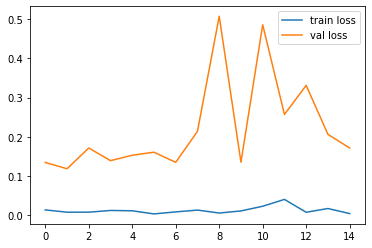

In [20]:
plt.plot(mdl.history['loss'], label = 'train loss')
plt.plot(mdl.history['val_loss'], label = 'val loss')
plt.legend()
plt.savefig('Loss plot')
plt.show()